# Model 1: Facial Skin Disease Detection
This model build using the InceptionV3 pre-trained model

In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

In [2]:

# Install required package
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import required package
import opendatasets as od
import pandas

kaggle_api = {"username":"muhammadlahiaardhan","key":"2aaa11d0796a5b8fb382e4ca203e8617"}

# Download Kaggle Dataset
od.download('https://www.kaggle.com/datasets/muhammadlahiaardhan/facial-skin-problemm', force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadlahiaardhan
Your Kaggle Key: ··········


100%|██████████| 101M/101M [00:01<00:00, 77.4MB/s] 


In [4]:
# Set the local path of the downloaded dataset folder
dataset_path = ('./facial-skin-problemm/dataset')

In [5]:
# Open the CSV file for writing labels
disease_list = ["acne", "blackhead", "wrinkles", "enlarged-pores", "redness", "dark-spot"]
with open(os.path.join(dataset_path, 'skin_disease_labels.csv'), "w", newline="") as file:
  writer = csv.writer(file)
  writer.writerow(['file', 'labels'])

  for folder_name in ["train", "validation", "test"]:
    for disease_name in disease_list:
      disease_path = os.path.join(dataset_path, folder_name, disease_name)
      for image_name in os.listdir(disease_path):
        writer.writerow([image_name, disease_name])
  
  print('labelling completed')

labelling completed


In [ ]:
import shutil

# Pindahin semua file ke satu folder yg sama
# Path to the source folders
train_folder = os.path.join(dataset_path, 'train')
valid_folder = os.path.join(dataset_path, 'validation')
test_folder = os.path.join(dataset_path, 'test')

# Path to the destination folder
destination_folder = './facial-skin-problemm/dataset/images'

# List of subfolders within each main folder
subfolders = ['acne', 'redness', 'enlarged-pores', 'blackhead', 'wrinkles', 'dark-spot']

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Iterate over the main folders
for folder in [train_folder, valid_folder, test_folder]:
    # Iterate over the subfolders within each main folder
    for subfolder in subfolders:
        # Path to the current subfolder
        subfolder_path = os.path.join(folder, subfolder)
        
        # Iterate over the files in the subfolder
        for file_name in os.listdir(subfolder_path):
            # Path to the current file
            file_path = os.path.join(subfolder_path, file_name)
            
            # Destination path to copy the file
            destination_path = os.path.join(destination_folder, file_name)
            
            # Copy the file to the destination folder
            shutil.copy(file_path, destination_path)

print("Files copied successfully!")

Files copied successfully!


In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join(dataset_path, 'skin_disease_labels.csv'))
df["labels"]=df["labels"].apply(lambda x:x.split(","))
print(df)

                 file       labels
0        acne-130.jpg       [acne]
1         acne-75.jpg       [acne]
2         acne-65.jpg       [acne]
3        acne-189.jpg       [acne]
4         acne-39.jpg       [acne]
..                ...          ...
993  dark-spot-21.jpg  [dark-spot]
994  dark-spot-59.jpg  [dark-spot]
995  dark-spot-67.jpg  [dark-spot]
996  dark-spot-95.jpg  [dark-spot]
997  dark-spot-36.jpg  [dark-spot]

[998 rows x 2 columns]


In [ ]:
# Assign Training, Validation, and Testing set
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')
test_dir = os.path.join(dataset_path, 'test')

# Membaca data dari file CSV yang berisi labelled data
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='nearest')
  
  validation_datagen = ImageDataGenerator(rescale=1/255.)

  train_generator = train_datagen.flow_from_dataframe(
      directory='./facial-skin-problemm/dataset/images',
      dataframe=df[:801],
      x_col="file",
      y_col="labels",
      batch_size=32,
      seed=42,
      shuffle=True,
      class_mode="categorical",
      classes=disease_list,
      target_size=(224,224)
  )

  validation_generator = validation_datagen.flow_from_dataframe(
      directory='./facial-skin-problemm/dataset/images',
      dataframe=df[801:900],
      x_col="file",
      y_col="labels",
      batch_size=32,
      seed=42,
      shuffle=True,
      class_mode="categorical",
      classes=disease_list,
      target_size=(224,224)
  )

  test_generator = validation_datagen.flow_from_dataframe(
      directory='./facial-skin-problemm/dataset/images',
      dataframe=df[900:999],
      x_col="file",
      batch_size=1,
      seed=42,
      shuffle=False,
      class_mode=None,
      target_size=(224,224)
  )

  # return train_generator, validation_generator
  return train_generator, validation_generator, test_generator

# train_generator, validation_generator = train_val_generators(train_dir, validation_dir, test_dir)
train_generator, validation_generator, test_generator = train_val_generators(train_dir, validation_dir, test_dir)

Found 800 validated image filenames belonging to 6 classes.
Found 99 validated image filenames belonging to 6 classes.
Found 98 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


# # Create Final Model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

87910968/87910968 [==============================] - 3s 0us/step


# # Train the Model

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Early Stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# conv 256
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=180,
                    callbacks=[reduce_lr])

Epoch 1/180
25/25 [==============================] - 87s 913ms/step - loss: 7.6005 - accuracy: 0.2225 - val_loss: 7.4665 - val_accuracy: 0.2323 - lr: 1.0000e-04
Epoch 2/180
25/25 [==============================] - 20s 809ms/step - loss: 7.2800 - accuracy: 0.4025 - val_loss: 7.1440 - val_accuracy: 0.3535 - lr: 1.0000e-04
Epoch 3/180
25/25 [==============================] - 19s 735ms/step - loss: 7.0317 - accuracy: 0.4425 - val_loss: 7.0200 - val_accuracy: 0.4040 - lr: 1.0000e-04
Epoch 4/180
25/25 [==============================] - 20s 808ms/step - loss: 6.7889 - accuracy: 0.4737 - val_loss: 6.6494 - val_accuracy: 0.5152 - lr: 1.0000e-04
Epoch 5/180
25/25 [==============================] - 19s 758ms/step - loss: 6.5477 - accuracy: 0.5337 - val_loss: 6.3500 - val_accuracy: 0.5657 - lr: 1.0000e-04
Epoch 6/180
25/25 [==============================] - 20s 798ms/step - loss: 6.3077 - accuracy: 0.5913 - val_loss: 6.1608 - val_accuracy: 0.5657 - lr: 1.0000e-04
Epoch 7/180
25/25 [===============

## Evaluate the Result

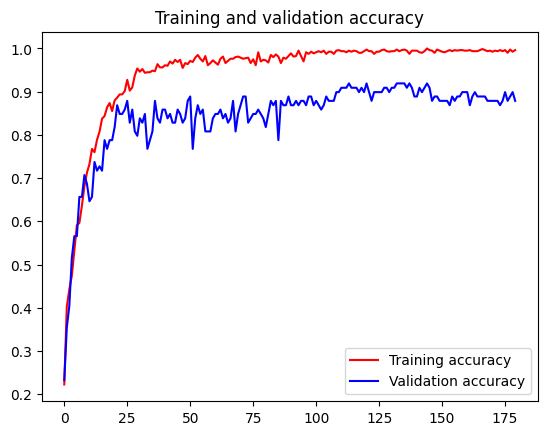

<Figure size 640x480 with 0 Axes>

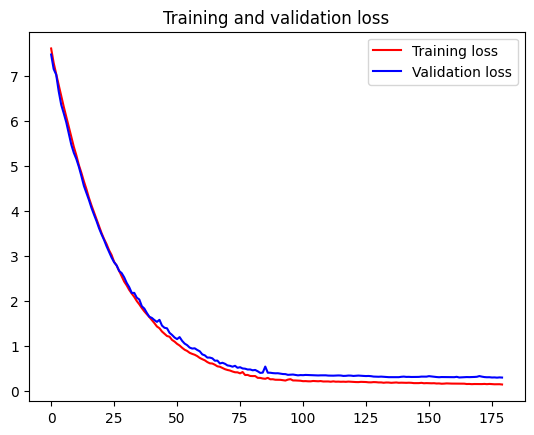

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

## Predict the Model

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

98/98 [==============================] - 4s 17ms/step


In [ ]:
pred_bool = (pred >0.5)
predictions=[]
labels = train_generator.class_indices
label = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(label[index])
    predictions.append(",".join(l))
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

In [ ]:
import tensorflow as tf
input_shape = (224, 224, 3)

def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Menambahkan dimensi batch
    img_array /= 255.0

    prediction = model.predict(img_array)
    labels = train_generator.class_indices
    labels = dict((v, k) for k, v in labels.items())

    predicted_labels = []
    confidence_levels = []
    for idx, val in enumerate(prediction[0]):
          predicted_labels.append(labels[idx])
          confidence_levels.append(val)

    return predicted_labels, confidence_levels

image_path = './facial-skin-problemm/dataset/test/dark-spot/dark-spot-95.jpg'
predictions, confidences = predict_image(image_path)

for i in range(len(predictions)):
    print(f"Disease: {predictions[i]} | Confidence: {confidences[i]*100:.2f}%")


1/1 [==============================] - 0s 32ms/step
Disease: acne | Confidence: 0.76%
Disease: blackhead | Confidence: 0.83%
Disease: wrinkles | Confidence: 0.35%
Disease: enlarged-pores | Confidence: 1.52%
Disease: redness | Confidence: 1.18%
Disease: dark-spot | Confidence: 100.00%


In [ ]:
model.save('model.h5')